# Comparing Ibis and Pandas on a Large Dataset (NYC Taxi) and Using JAX for Classification

## Understanding Ibis

### What is Ibis?

[Ibis](https://ibis-project.org/) is a Python library that provides a high-level, Pandas-like API for interacting with various backend databases. It allows users to write Pythonic queries that are translated into SQL or other backend-specific query languages, enabling efficient data analysis without needing to write raw SQL.

### Key Features of Ibis

- **Backend Agnostic:** Ibis supports multiple backends such as DuckDB, BigQuery, PostgreSQL, ClickHouse, and more. This means you can switch databases without changing your Ibis code.
- **Lazy Evaluation:** Ibis builds an expression tree representing your queries. Computations are deferred until you explicitly execute the query using `.execute()`. This approach optimizes query execution and reduces memory usage.
- **Pandas-like API:** If you're familiar with Pandas, Ibis will feel intuitive. It offers similar functions like `.filter()`, `.select()`, `.mutate()`, `.group_by()`, and `.aggregate()`.
- **Scalability:** By leveraging the power of backend databases, Ibis can handle large datasets that might not fit into memory, unlike Pandas which operates in-memory.

### How to Set Up Ibis

1. **Installation:**
```bash
pip install ibis-framework duckdb-engine
```

`ibis-framework`: The core Ibis library.
`duckdb-engine`: Backend support for DuckDB.

#### Connecting to a Backend:
```python
import ibis
con = ibis.duckdb.connect(':memory:')  # In-memory DuckDB connection
```

**DuckDB:** An in-process SQL OLAP database management system that is efficient and easy to use.

#### Loading Data:
```python
trips = con.read_parquet('yellow_tripdata_2021-01.parquet', table_name='trips')
```
This registers the Parquet file as a table in DuckDB. Note that Ibis does not load all data into memory immediately.

### Key Ibis Functions and Objects

**Table Expressions:** Represent tables in your backend database.
```python
trips = con.read_parquet('yellow_tripdata_2021-01.parquet', table_name='trips')
```

**Filtering Data:**
```python
children = trips.filter(trips.Age < 18)
```

**Selecting Columns:**
```python
selected = trips.select(['trip_distance', 'fare_amount'])
```

**Mutating Data:**
```python
mutated = trips.mutate(
    tip_label=(trips.tip_amount > 0).cast('int32'),
    pickup_hour=trips.tpep_pickup_datetime.hour()
)
```

**Grouping and Aggregation:**
```python
agg = trips.group_by('Sex').aggregate(avg_fare=trips.fare_amount.mean())
```

**Executing Queries:**
```python
result_df = agg.execute()  # Converts the Ibis expression to a Pandas DataFrame
```

### Comparison with Pandas

| Aspect         | Ibis                                      | Pandas                                     |
|----------------|-------------------------------------------|---------------------------------------------|
| Execution Model | Lazy (deferred execution)                | Eager (immediate execution)                 |
| Backend Support | Multiple (DuckDB, BigQuery, etc.)        | In-memory only                              |
| Scalability     | High (leverages backend databases)       | Limited by available memory                 |
| API Familiarity | Pandas-like, SQL-inspired                | DataFrame-centric                           |
| Performance     | Optimized for large datasets/complex qs. | Fast for in-memory operations on small data |
| Use Case        | Big data analytics, scalable querying    | Data manipulation, exploratory analysis      |


### When to Use Ibis
- **Large Datasets:** When working with data that doesn't fit into memory.
- **Backend Flexibility:** When you need to switch between different database systems.
- **Complex Queries:** When performing multi-step aggregations and joins that benefit from database optimizations.

### Example Workflow with Ibis

```python
# Connect to Backend:
con = ibis.duckdb.connect(':memory:')

# Load Data:
trips = con.read_parquet('yellow_tripdata_2021-01.parquet', table_name='trips')

# Transform Data:
prep = trips.filter([
    trips.trip_distance > 0,
    trips.fare_amount > 0
]).mutate(
    tip_label=(trips.tip_amount > 0).cast('int32'),
    pickup_hour=trips.tpep_pickup_datetime.hour()
)

# Execute Query and Load into Pandas:
model_df = prep[['tip_label', 'trip_distance', 'fare_amount', 'passenger_count', 'pickup_hour']].limit(200_000).execute()
```

Ibis provides a powerful abstraction for handling large-scale data analysis tasks efficiently by leveraging the strengths of backend databases while maintaining a user-friendly, Pandas-like interface.

# Comparing Ibis and Pandas on a Large Dataset (NYC Taxi) and Using JAX for Classification

## Overview
This notebook provides a **comprehensive demonstration** of working with a large real-world dataset, the **NYC Taxi** data, using two different data handling approaches: **Ibis (with DuckDB)** and **Pandas**.

We will:
1. **Load and query large data**: Show how Ibis differs from Pandas in loading and querying a large dataset.
   - We’ll measure load times, perform sample queries, and discuss pros and cons.
   - Ibis allows pushing queries into DuckDB, potentially improving performance and scalability.

2. **Data Preprocessing for Classification**: We’ll define a binary classification task:
   - Predict whether a taxi trip included a positive tip (`tip_amount > 0`) using features like `trip_distance`, `fare_amount`, `passenger_count`, and `pickup_hour`.

3. **Classification Models**:
   - **Baseline (Scikit-learn)**: We'll use a simple logistic regression model as a baseline.
   - **JAX Implementation**: We’ll go deeper into JAX:
       - Implement a logistic regression model from scratch.
       - Implement a small neural network classifier from scratch to show how JAX can handle more complex models.

4. **Comparison and Visualization**:
   - We’ll compare the performance (accuracy, F1-score) of the scikit-learn baseline, JAX logistic regression, and JAX neural network.
   - Use confusion matrices and plots to visualize results.
   - Discuss differences in performance and what might influence these results.

This notebook includes extensive explanations in the markdown cells so that even if you're new to Ibis, Pandas, or JAX, you can understand the reasoning behind each step.


In [1]:
!pip install --quiet ibis-framework duckdb-engine jax jaxlib numpy pandas pyarrow matplotlib scikit-learn optax

## Imports and Configuration
We first import all the necessary libraries.
- **ibis** and **duckdb-engine**: For Ibis and DuckDB integration.
- **pandas** and **numpy**: For data manipulation and arrays.
- **matplotlib**: For plotting graphs.
- **scikit-learn**: For the baseline logistic regression model.
- **jax**, **optax**: For building and training models in JAX.

We also set a plotting style for better visuals.

In [2]:
import ibis
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import optax
from jax import config
config.update("jax_enable_x64", True)

# Use a built-in matplotlib style
plt.style.use('ggplot')

## Data: NYC Taxi (January 2021)
We’ll use the **January 2021 NYC Yellow Taxi dataset**, which can be large (hundreds of MBs or more). A large dataset helps illustrate the scalability advantages of Ibis.

**File:** `yellow_tripdata_2021-01.parquet`

### Classification Task
We define a binary classification problem:
- Label: `tip_label = 1 if tip_amount > 0 else 0`
- Features: `trip_distance`, `fare_amount`, `passenger_count`, `pickup_hour`.

Why this task?
- It’s simple and intuitive: We want to know if the trip resulted in a tip.
- Suitable for logistic regression and neural networks.

We’ll first compare how Pandas and Ibis load and query the data.

## Loading Data with Pandas
Pandas loads data eagerly into memory:
- Pros: Once loaded, very fast for in-memory computations.
- Cons: Large datasets can be slow to load and memory-consuming.

We’ll measure the load time.

In [3]:
start = time.time()
pdf = pd.read_parquet('yellow_tripdata_2021-01.parquet')
end = time.time()
pandas_load_time = end - start
print(f"Pandas load time: {pandas_load_time:.2f} seconds")
pdf.head()

Pandas load time: 1.77 seconds


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN


Pandas now has all data in `pdf`. For very large datasets, this could be many gigabytes of memory.

## Loading Data with Ibis
Ibis lets us connect to a DuckDB backend and reference the Parquet file without fully loading it:
- Pros: Quick to set up references, deferred computation.
- Cons: Slightly more complex queries, might not be as straightforward as Pandas for small data.

We measure the time to register the Parquet file with Ibis.

In [4]:
con = ibis.duckdb.connect(':memory:')
start = time.time()
trips = con.read_parquet('yellow_tripdata_2021-01.parquet', table_name='trips')
end = time.time()
ibis_load_time = end - start
print(f"Ibis (DuckDB) load time (registration only): {ibis_load_time:.2f} seconds")
trips

Ibis (DuckDB) load time (registration only): 0.04 seconds


DatabaseTable: trips
  VendorID              int64
  tpep_pickup_datetime  timestamp(6)
  tpep_dropoff_datetime timestamp(6)
  passenger_count       float64
  trip_distance         float64
  RatecodeID            float64
  store_and_fwd_flag    string
  PULocationID          int64
  DOLocationID          int64
  payment_type          int64
  fare_amount           float64
  extra                 float64
  mta_tax               float64
  tip_amount            float64
  tolls_amount          float64
  improvement_surcharge float64
  total_amount          float64
  congestion_surcharge  float64
  airport_fee           float64

**Note:** The Ibis load step doesn't load all data into memory. It just sets up a reference in DuckDB. The real data loading and processing happen when we run `.execute()` on queries.

## Querying Data
Let's run a simple aggregation query using both Pandas and Ibis:
- Compute the mean fare.

This will show how long it takes in each framework.

In [5]:
# Ibis query: mean fare
start = time.time()
avg_fare_ibis = trips.fare_amount.mean().execute()
end = time.time()
ibis_query_time = end - start
print(f"Ibis avg fare query time: {ibis_query_time:.4f}s, Avg fare: {avg_fare_ibis:.2f}")

# Pandas query: mean fare
start = time.time()
avg_fare_pd = pdf['fare_amount'].mean()
end = time.time()
pandas_query_time = end - start
print(f"Pandas avg fare query time: {pandas_query_time:.4f}s, Avg fare: {avg_fare_pd:.2f}")

Ibis avg fare query time: 0.0934s, Avg fare: 12.10
Pandas avg fare query time: 0.0090s, Avg fare: 12.10


For large, complex queries (e.g., joins, multiple aggregates), Ibis+DuckDB can shine by pushing computation down into DuckDB. Pandas would require loading all data into memory first.

### Visual Comparison of Load and Query Times
Let's plot load times and query times side by side to visually compare.


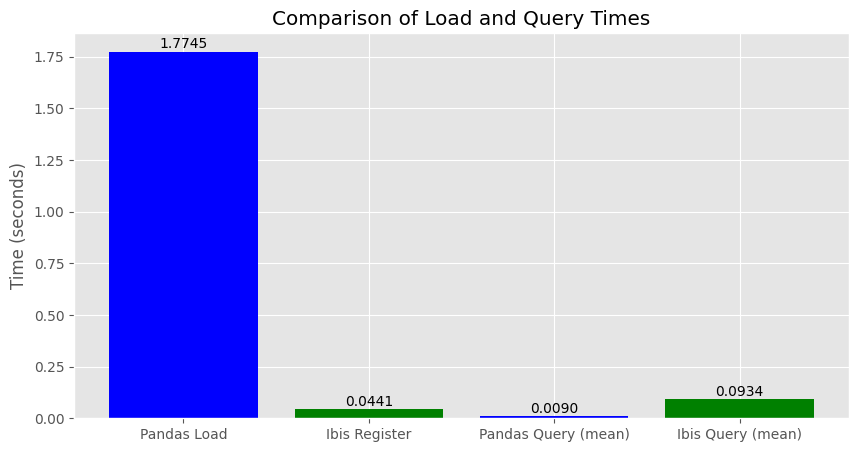

In [6]:
methods = ['Pandas Load', 'Ibis Register', 'Pandas Query (mean)', 'Ibis Query (mean)']
times = [pandas_load_time, ibis_load_time, pandas_query_time, ibis_query_time]

plt.figure(figsize=(10,5))
plt.bar(methods, times, color=['blue','green','blue','green'])
plt.title('Comparison of Load and Query Times')
plt.ylabel('Time (seconds)')
for i, t in enumerate(times):
    plt.text(i, t+0.001, f"{t:.4f}", ha='center', va='bottom')
plt.show()

From this comparison:
- Pandas load might be slower because it actually loads data.
- Ibis registration is fast but doesn't mean the data is fully read yet.
- Query times vary; for a mean aggregation, both might be fast, but Ibis can excel on more complex queries.

## Data Preparation for Classification
We now define our classification label and filter data. Steps:
1. Filter out unrealistic trips (non-positive distance or fare).
2. Create `tip_label` (1 if tip_amount > 0 else 0).
3. Extract `pickup_hour` from `tpep_pickup_datetime`.

We'll use Ibis for these transformations and then `execute()` to bring a sample into memory.

In [7]:
prep = trips.filter([
    trips.trip_distance > 0,
    trips.fare_amount > 0
]).mutate(
    tip_label=(trips.tip_amount > 0).cast('int32'),
    pickup_hour=trips.tpep_pickup_datetime.hour()
)

We have a very large dataset. We'll sample a subset (e.g., 500k rows) to speed up training and experimentation.
In a real scenario, you can use more rows if you have the compute resources.

In [8]:
sample_size = 500_000
start = time.time()
model_df = prep[['tip_label', 'trip_distance', 'fare_amount', 'passenger_count', 'pickup_hour']].limit(sample_size).execute()
end = time.time()
print(f"Fetched sample of {sample_size} rows in {end - start:.2f} seconds")
model_df.head()

Fetched sample of 500000 rows in 0.33 seconds


,tip_label,trip_distance,fare_amount,passenger_count,pickup_hour
0,0,2.10,8.0,1.0,0
1,0,0.20,3.0,1.0,0
2,1,14.70,42.0,1.0,0
3,1,10.60,29.0,0.0,0
4,1,4.94,16.5,1.0,0


Check the distribution of our target label (`tip_label`):

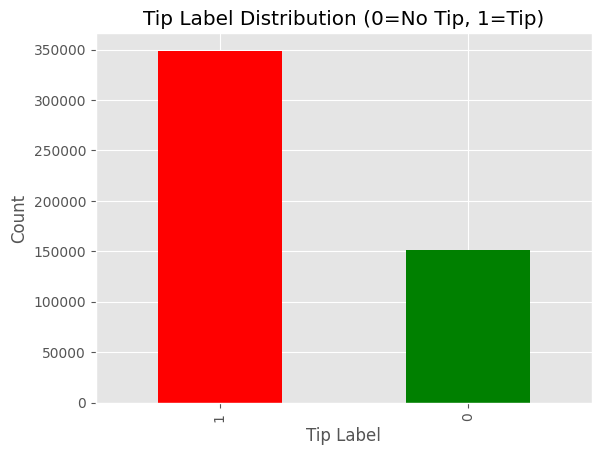

In [9]:
model_df['tip_label'].value_counts().plot(kind='bar', color=['red','green'])
plt.title('Tip Label Distribution (0=No Tip, 1=Tip)')
plt.xlabel('Tip Label')
plt.ylabel('Count')
plt.show()

We have a large sample. The classes might be imbalanced. Now, let's split into train/test sets.

In [10]:
X = model_df[['trip_distance', 'fare_amount', 'passenger_count', 'pickup_hour']].to_numpy()
y = model_df['tip_label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)

## Baseline Model with Scikit-learn
We start with a **Logistic Regression** from scikit-learn:
- Pros: Easy, well-optimized, a good baseline.
- Cons: Less flexible than a custom JAX model.


In [11]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred_sklearn = clf.predict(X_test)
acc_sklearn = accuracy_score(y_test, y_pred_sklearn)
f1_sklearn = f1_score(y_test, y_pred_sklearn)

print("Scikit-learn Logistic Regression:")
print("Accuracy:", acc_sklearn)
print("F1-Score:", f1_sklearn)

Scikit-learn Logistic Regression:
Accuracy: 0.70016
F1-Score: 0.8236359786368022


Confusion matrix to understand predictions more deeply:

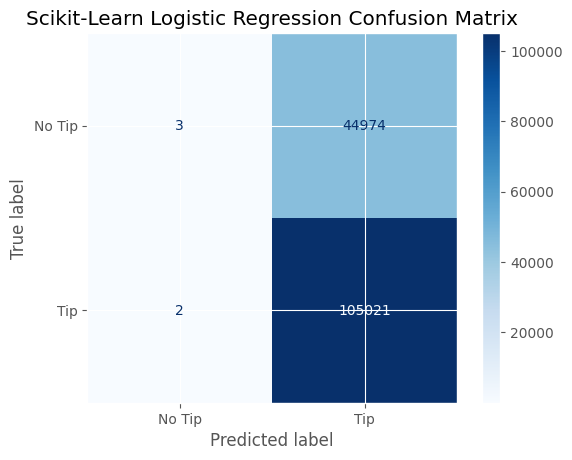

In [12]:
cm = confusion_matrix(y_test, y_pred_sklearn)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Tip", "Tip"])
disp.plot(cmap='Blues')
plt.title('Scikit-Learn Logistic Regression Confusion Matrix')
plt.show()

## Understanding JAX

### What is JAX?

[JAX](https://github.com/google/jax) is a high-performance numerical computing library for Python developed by Google. It extends NumPy with features like automatic differentiation, just-in-time (JIT) compilation, and vectorization, making it a versatile tool for machine learning research and scientific computing.

### Key Features of JAX

- **Automatic Differentiation (Autograd):** JAX can automatically compute gradients of functions, essential for training machine learning models.
- **JIT Compilation:** Using XLA, JAX can compile and optimize your Python functions, resulting in significant speedups.
- **Vectorization:** The `vmap` function enables batch processing without explicit loops.
- **GPU/TPU Support:** JAX runs seamlessly on GPUs and TPUs.
- **Functional Programming Paradigm:** Encourages functional, immutable code for more predictable and debuggable workflows.

### How to Set Up JAX

1. **Installation:**
```bash
pip install --upgrade pip
pip install jax jaxlib  # For CPU
```

For GPU support, refer to JAX's installation instructions.

### Basic Usage

```python
import jax
import jax.numpy as jnp

# Define a simple function
def f(x):
    return x**2 + 2*x + 1

# Compute gradient
grad_f = jax.grad(f)
print(grad_f(3.0))  # Output: 8.0
```

### Common JAX Functions and Syntax
- `jax.numpy (jnp)`: NumPy-compatible API.
- `jax.grad(fun)`: Computes gradient of `fun`.
- `jax.jit(fun)`: Compiles `fun` for faster execution.
- `jax.vmap(fun)`: Vectorizes `fun`.
- `optax`: A separate library providing optimizers and gradient processing.

### JAX vs. Traditional Libraries

| Aspect            | JAX                                      | Traditional (e.g., NumPy, scikit-learn) |
|-------------------|-------------------------------------------|-----------------------------------------|
| Differentiation   | Automatic differentiation built-in         | Manual or limited                       |
| Compilation       | JIT compilation with XLA                  | No compilation                          |
| Vectorization     | Automatic with `vmap`                     | Manual vectorization                    |
| Flexibility       | Highly flexible custom models             | Predefined models/APIs                  |
| Performance       | Optimized for accelerators and large data | Depends on library/implementation        |
| Programming Style | Functional, immutable                     | Procedural, mutable                     |

### When to Use JAX
- **Research and Custom Models:** For custom machine learning models.
- **Performance-Critical Apps:** Leveraging JIT and hardware acceleration.
- **Automatic Differentiation:** Simplifying gradient computations.

### Example Workflow with JAX

**Define a Function and Compute Gradient:**
```python
import jax.numpy as jnp
from jax import grad

def quadratic(x):
    return jnp.dot(x, x)

grad_quadratic = grad(quadratic)
x = jnp.array([1.0, 2.0, 3.0])
print(grad_quadratic(x))  # Output: [2.0, 4.0, 6.0]
```

**JIT Compilation:**
```python
from jax import jit

@jit
def compute_sum(x):
    return jnp.sum(x)

x = jnp.ones(1000000)
print(compute_sum(x))  # Fast due to JIT compilation
```

**Vectorization with `vmap`:**
```python
from jax import vmap

def add_one(x):
    return x + 1

add_one_vectorized = vmap(add_one)
x = jnp.array([1, 2, 3, 4, 5])
print(add_one_vectorized(x))  # [2, 3, 4, 5, 6]
```

### JAX in Machine Learning

JAX is powerful for building and training models from scratch, offering flexibility and performance advantages over traditional libraries.

**Example: Logistic Regression in JAX**
```python
import jax.numpy as jnp
from jax import grad

def sigmoid(z):
    return 1 / (1 + jnp.exp(-z))

def predict(params, X):
    w, b = params
    return sigmoid(jnp.dot(X, w) + b)

def loss_fn(params, X, y):
    predictions = predict(params, X)
    return -jnp.mean(y * jnp.log(predictions) + (1 - y) * jnp.log(1 - predictions))

# Initialize parameters
w = jnp.zeros((10,))  # Example feature dimension
b = 0.0
params = (w, b)

gradients = grad(loss_fn)(params, jnp.ones((1,10)), jnp.array([1]))

# Update parameters (as an example)
learning_rate = 0.01
w = w - learning_rate * gradients[0]
b = b - learning_rate * gradients[1]
params = (w, b)
```

### Conclusion
JAX stands out for performance, flexibility, and ease of applying automatic differentiation. Although it may have a steeper learning curve than some traditional libraries, the advantages in performance and scalability make it a strong choice for advanced research and large-scale machine learning applications.

## Introducing JAX for ML Models
JAX provides:
- Automatic differentiation: We write a loss function, JAX can compute gradients for us.
- XLA compilation: Potentially faster execution.
- Full control: We can implement any model, from linear to neural networks, without being restricted to standard estimators.

We will implement:
1. **Logistic Regression in JAX**: Similar to scikit-learn model but fully custom.
2. **A Simple Neural Network in JAX**: A small MLP (Multi-Layer Perceptron) classifier to see if a non-linear model improves performance.


### JAX Setup
Convert data to JAX arrays and define helper functions.

**Note:** We’ll use optax for optimizers, and just-in-time (jit) compilation for speed.


In [13]:
X_train_j = jnp.array(X_train)
y_train_j = jnp.array(y_train)
X_test_j = jnp.array(X_test)
y_test_j = jnp.array(y_test)

### JAX Logistic Regression
**Model:**
p = sigmoid(Xw + b)
Loss: Binary cross-entropy

We’ll add L1 regularization for controlling complexity.

**Steps:**
1. Initialize parameters (small random values).
2. Define `predict_jax` and `loss_fn`.
3. Use optax's Adam optimizer.
4. Train for a number of epochs.
5. Evaluate the model.


In [15]:
import optax

def sigmoid(z):
    return 1/(1+jnp.exp(-z))

def predict_jax(params, X):
    w, b = params
    return sigmoid(jnp.dot(X, w) + b)

def loss_fn(params, X, y, l1_reg=1e-4):
    w, b = params
    p = predict_jax(params, X)
    eps = 1e-8
    # Binary cross-entropy loss
    loss = -jnp.mean(y*jnp.log(p+eps) + (1-y)*jnp.log(1-p+eps))
    # L1 regularization to encourage sparsity
    l1_penalty = l1_reg * jnp.sum(jnp.abs(w))
    return loss + l1_penalty

# Parameter initialization
key = jax.random.PRNGKey(16)
w_init = jax.random.normal(key, shape=(X_train_j.shape[1],)) * 0.01
b_init = 0.0
params = (w_init, b_init)

# Optimizer
learning_rate = 0.01
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, opt_state, X, y):
    grads = jax.grad(loss_fn)(params, X, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    loss = loss_fn(new_params, X, y)
    return new_params, opt_state, loss

# Training loop
epochs = 300
for epoch in range(epochs):
    params, opt_state, loss = train_step(params, opt_state, X_train_j, y_train_j)
    if epoch % 100 == 0:
        print(f"JAX Logistic Regression Epoch {epoch}: Loss={loss:.4f}")

w_final, b_final = params
print("JAX Logistic Regression Training Complete.")

JAX Logistic Regression Epoch 0: Loss=0.6618
JAX Logistic Regression Epoch 100: Loss=0.6147
JAX Logistic Regression Epoch 200: Loss=0.6135
JAX Logistic Regression Training Complete.


Evaluate JAX logistic regression model on test set:

JAX Logistic Regression:
Accuracy: 0.7001733333333333
F1-Score: 0.8236452042977022


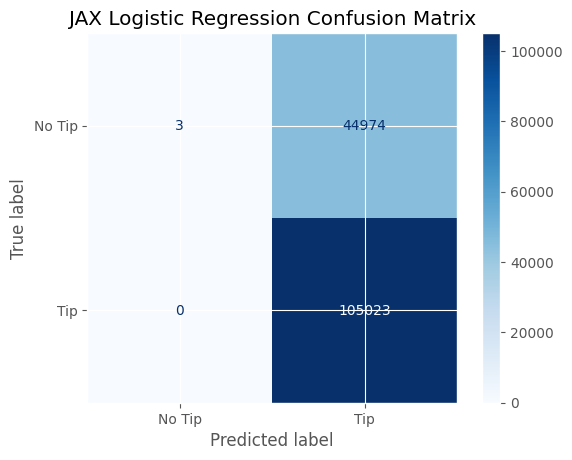

In [16]:
p_test = predict_jax(params, X_test_j)
y_pred_jax_logreg = (p_test > 0.5).astype(int)

acc_jax_logreg = accuracy_score(y_test, np.array(y_pred_jax_logreg))
f1_jax_logreg = f1_score(y_test, np.array(y_pred_jax_logreg))

print("JAX Logistic Regression:")
print("Accuracy:", acc_jax_logreg)
print("F1-Score:", f1_jax_logreg)

cm_jax_logreg = confusion_matrix(y_test, np.array(y_pred_jax_logreg))
disp = ConfusionMatrixDisplay(cm_jax_logreg, display_labels=["No Tip", "Tip"])
disp.plot(cmap='Blues')
plt.title('JAX Logistic Regression Confusion Matrix')
plt.show()

## JAX Neural Network Classifier
Let's try a simple 2-layer MLP (Multi-Layer Perceptron):
```
Input -> Dense Layer (e.g. 16 units, ReLU) -> Dense Layer (1 unit, sigmoid)
```

Why a neural network?
- Non-linear model might capture more complex relationships.
- Demonstrates how JAX can build more complex models than logistic regression.

### Model Definition Steps:
1. Initialize parameters for each layer (weights and biases).
2. Define a forward pass function.
3. Use the same binary cross-entropy loss.

We’ll keep it small and simple.

In [17]:
def init_mlp_params(key, input_dim, hidden_dim=50):
    key1, key2 = jax.random.split(key)
    W1 = jax.random.normal(key1, shape=(input_dim, hidden_dim))*0.01
    b1 = jnp.zeros(hidden_dim)
    W2 = jax.random.normal(key2, shape=(hidden_dim, 1))*0.01
    b2 = jnp.zeros(1)
    return (W1, b1, W2, b2)

def mlp_forward(params, X):
    W1, b1, W2, b2 = params
    hidden = jnp.maximum(0, jnp.dot(X, W1) + b1)  # ReLU
    logits = jnp.dot(hidden, W2) + b2
    return sigmoid(logits).reshape(-1)

def mlp_loss_fn(params, X, y):
    p = mlp_forward(params, X)
    eps = 1e-8
    loss = -jnp.mean(y*jnp.log(p+eps) + (1-y)*jnp.log(1-p+eps))
    return loss


Initialize MLP parameters and optimizer:

In [19]:

mlp_key = jax.random.PRNGKey(2)
mlp_params = init_mlp_params(mlp_key, X_train_j.shape[1])
mlp_optimizer = optax.adam(0.001)
mlp_opt_state = mlp_optimizer.init(mlp_params)

@jax.jit
def mlp_train_step(params, opt_state, X, y):
    grads = jax.grad(mlp_loss_fn)(params, X, y)
    updates, opt_state = mlp_optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    loss = mlp_loss_fn(new_params, X, y)
    return new_params, opt_state, loss

mlp_epochs = 600  # more epochs
for epoch in range(mlp_epochs):
    mlp_params, mlp_opt_state, mlp_loss = mlp_train_step(mlp_params, mlp_opt_state, X_train_j, y_train_j)
    if epoch % 200 == 0:
        print(f"JAX MLP Epoch {epoch}: Loss={mlp_loss:.4f}")

JAX MLP Epoch 0: Loss=0.6900
JAX MLP Epoch 200: Loss=0.6116
JAX MLP Epoch 400: Loss=0.6093


Evaluate MLP on test data:

JAX MLP:
Accuracy: 0.7004066666666666
F1-Score: 0.8236559055396194


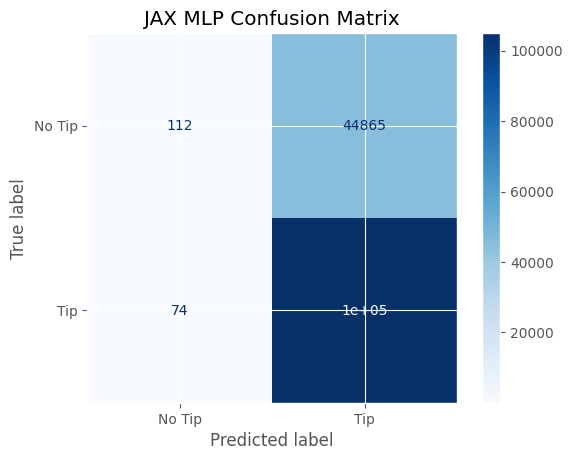

In [20]:
p_test_mlp = mlp_forward(mlp_params, X_test_j)
y_pred_mlp = (p_test_mlp > 0.5).astype(int)

acc_mlp = accuracy_score(y_test, np.array(y_pred_mlp))
f1_mlp = f1_score(y_test, np.array(y_pred_mlp))

print("JAX MLP:")
print("Accuracy:", acc_mlp)
print("F1-Score:", f1_mlp)

cm_mlp = confusion_matrix(y_test, np.array(y_pred_mlp))
disp = ConfusionMatrixDisplay(cm_mlp, display_labels=["No Tip", "Tip"])
disp.plot(cmap='Blues')
plt.title('JAX MLP Confusion Matrix')
plt.show()

## Comparison of All Models
We now have three models:
1. Scikit-Learn Logistic Regression (Baseline)
2. JAX Logistic Regression
3. JAX MLP

Let's put their accuracy and F1-scores side by side in a plot.

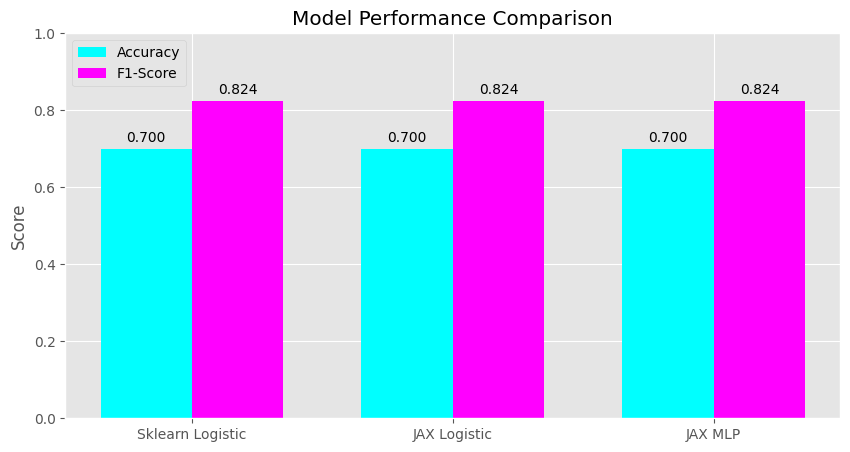

In [21]:
models = ['Sklearn Logistic', 'JAX Logistic', 'JAX MLP']
accs = [acc_sklearn, acc_jax_logreg, acc_mlp]
f1s = [f1_sklearn, f1_jax_logreg, f1_mlp]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, accs, width, label='Accuracy', color='cyan')
plt.bar(x + width/2, f1s, width, label='F1-Score', color='magenta')
plt.xticks(x, models)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim([0,1])
for i, v in enumerate(accs):
    plt.text(i - width/2, v+0.01, f"{v:.3f}", ha='center', va='bottom')
for i, v in enumerate(f1s):
    plt.text(i + width/2, v+0.01, f"{v:.3f}", ha='center', va='bottom')
plt.legend()
plt.show()

## Discussion and Conclusions

### Ibis vs Pandas:
- **Pandas**: Loads data eagerly, easy to use for small to medium datasets. Once loaded, operations are fast but memory-hungry.
- **Ibis (with DuckDB)**: More scalable, can push complex queries down to DuckDB. Suitable for large datasets where you don't want to load everything at once. It can be more complex but is powerful for big data.

The visual comparisons and timing measurements show that Ibis can register and query data efficiently. Pandas is straightforward but might struggle with memory if the dataset grows very large.

### Models:
We tested three models:
1. **Scikit-learn Logistic Regression**: Strong baseline, easy to implement.
2. **JAX Logistic Regression**: Shows how we can replicate the baseline model in JAX with full control and add custom regularization.
3. **JAX MLP (Neural Network)**: Introduces non-linearity and can potentially capture more complex patterns.

In practice, the performance differences might be small if the data doesn't require complex boundaries. However, the MLP may improve slightly with tuning (more layers, different learning rates, more epochs).

### Understanding JAX:
- JAX allows automatic differentiation, so we don't write gradient formulas by hand.
- Using `optax` and `jax.jit` can speed up training loops.
- We have flexibility: we can implement any model (logistic regression, neural networks, etc.).

### Potential Improvements:
- Use more features (pickup/dropoff locations, day of week, weather) for better models.
- Tune hyperparameters (learning rate, regularization strength, hidden layer size) for the MLP.
- Try different optimizers, more epochs, or early stopping.

### Key Takeaways:
1. **Data Handling**: Ibis excels with large data and can save memory and time by pushing computations into a database (DuckDB). Pandas is simpler but may struggle with huge datasets.
2. **Modeling**: JAX provides ultimate flexibility at the cost of more coding. Scikit-learn is user-friendly and quick.
3. **Scaling Up**: For massive data and complex models, Ibis + JAX can be a powerful combination, enabling distributed or accelerated computing.

We’ve now seen how to:
- Load and query large data with Ibis and Pandas.
- Define a classification problem and preprocess data efficiently.
- Implement and compare multiple models (logistic regression and MLP) using scikit-learn and JAX.

This should give a strong foundation to approach more complex big-data analytics and custom ML model building.